# CS4035 - Cyber Data Analytics
## Lab 2 - PCA/Regression task

## Group Number : 21

## Student 2
### Name : Michał Okoń
### ID :

In [209]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import ccf

In [210]:
# If this cell does not work try running ``

import io
import nbformat

nb = nbformat.read("Lab2-PCA-Regression.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 529


## 0. Data Loading

#### Loading into pandas dataframe

In [211]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

In [212]:
# Excluding the time frame and the target variable and backup signals
relevant_signals = ['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401',
                    'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503',
                    'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'MV101', 'P101', 'MV201', 'P203', 'P205', 'MV301',
                    'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'UV401', 'P501', 'P602']
relevant_train_data_df = train_data_df[relevant_signals]
relevant_train_data_df

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV301,MV302,MV303,MV304,P301,P302,P402,UV401,P501,P602
Id,,,,,,,,,,,,,,,,,,,,,
0,2.470294,261.5804,244.3284,8.190080,306.1010,2.471278,20.79839,2.235275,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
1,2.457163,261.1879,244.3284,8.190080,306.1010,2.468587,20.79839,2.234507,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
2,2.439548,260.9131,244.3284,8.190080,306.1010,2.467305,20.84320,2.233354,327.4401,0.000,...,1,2,1,1,2,1,1,1,1,1
3,2.428338,260.2850,244.3284,8.190080,306.1010,2.466536,20.84320,2.233354,327.2799,0.000,...,1,2,1,1,2,1,1,1,1,1
4,2.424815,259.8925,244.4245,8.190080,306.1010,2.466536,20.84320,2.233354,327.1597,0.000,...,1,2,1,1,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496795,2.460366,523.0430,262.0161,8.396437,328.5055,2.442316,19.74838,2.212087,955.8046,148.808,...,1,2,1,1,1,2,2,2,2,1
496796,2.448836,522.9645,262.0161,8.396437,328.5055,2.442316,19.74838,2.210037,955.8847,148.808,...,1,2,1,1,1,2,2,2,2,1
496797,2.434744,522.8860,262.0161,8.396437,328.6337,2.444879,19.74838,2.207731,955.9648,148.808,...,1,2,1,1,1,2,2,2,2,1


In [213]:
test_data_df

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
Id,,,,,,,,,,,,,,,,,,,,,
224959,31/12/2015 12:29:19 AM,2.612177,517.6261,2,2,1,192.2263,8.530376,324.2758,2.443597,...,0.306825,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224960,31/12/2015 12:29:20 AM,2.612177,517.7831,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,250.0000,0.816967,188.4613,0.0,1,1,1
224961,31/12/2015 12:29:21 AM,2.594562,518.2149,2,2,1,192.2263,8.531017,324.2758,2.443597,...,0.306441,2,1,249.9840,0.816967,188.4613,0.0,1,1,1
224962,31/12/2015 12:29:22 AM,2.577907,518.7645,2,2,1,192.2263,8.531017,324.2758,2.442060,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
224963,31/12/2015 12:29:23 AM,2.562854,519.1177,2,2,1,192.2263,8.531017,324.2758,2.441419,...,0.306441,2,1,249.7597,0.816967,188.4613,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.1535,0.865024,189.0220,0.0,1,1,1
449915,2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1
449916,2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,0.306569,2,1,251.0734,0.865024,188.9259,0.0,1,1,1


## 3. PCA task – 1/2 A4 – Individual

### 3a. Plot PCA residuals

Main functions used to perform the PCA and plot the residuals.

In [214]:
def get_pca_residuals(df, components=None):
    total_residuals = []
    if components is None:
        component_range = range(1, len(df.columns))
    else:
        component_range = components
    for n_components in component_range:
        pca = PCA(n_components=n_components)
        pca.fit(df)
        # Calculate residuals
        residuals = calculate_residuals(df, pca)
        total_residuals.append(residuals)
    return total_residuals


def plot_pca_residuals(residuals, components, start_index=0, true_labels=None, predicted_labels=None):
    print(residuals)
    print(true_labels)
    plt.clf()
    x = np.arange(start_index, len(residuals[0]))
    for i, residual in enumerate(residuals):
        plt.plot(x, residual[start_index:], label=f'{components[i]}')
        if true_labels is not None:
            plt.scatter(true_labels, residual[true_labels], label="True anomalies", color="green", s=20)
        if predicted_labels is not None:
            plt.scatter(predicted_labels, residual[predicted_labels], label="Predicted anomalies", color="blue", s=10)
    plt.legend()
    plt.title('PCA Residuals for different number of components')
    plt.show()


def calculate_residuals(df, pca):
    return np.sum(np.abs(df - pca.inverse_transform(pca.transform(df))), axis=1)

Perform the residual analysis.

In [215]:
components = np.arange(1, len(relevant_train_data_df.columns))

In [216]:
partial_components1 = [1, 2, 5]
partial_residuals1 = get_pca_residuals(relevant_train_data_df, components=partial_components1)

In [217]:
partial_components2 = [10, 15, 20]
partial_residuals2 = get_pca_residuals(relevant_train_data_df, components=partial_components2)

In [218]:
partial_components3 = [25, 30, 35]
partial_residuals3 = get_pca_residuals(relevant_train_data_df, components=partial_components3)

[Id
0         917.850006
1         917.549624
2         917.456992
3         916.830748
4         916.143625
             ...    
496795    239.042057
496796    239.653358
496797    239.808106
496798    239.750478
496799    239.753180
Length: 496800, dtype: float64, Id
0         734.378942
1         734.462915
2         734.609380
3         734.518173
4         734.184842
             ...    
496795     95.552191
496796     95.856484
496797     95.637299
496798     96.171168
496799     95.877102
Length: 496800, dtype: float64, Id
0         259.450552
1         259.370611
2         259.352427
3         259.261923
4         259.126240
             ...    
496795     40.628534
496796     40.549251
496797     40.628583
496798     40.754636
496799     40.735714
Length: 496800, dtype: float64]
None


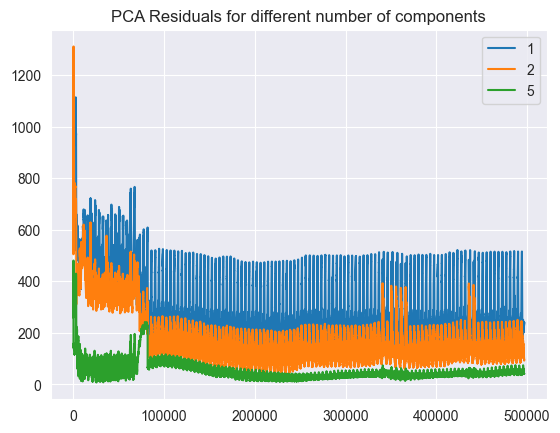

[Id
0         29.049197
1         28.999717
2         28.985669
3         28.958254
4         28.926857
            ...    
496795     4.583425
496796     4.498623
496797     4.500494
496798     4.222863
496799     4.143299
Length: 496800, dtype: float64, Id
0         10.928172
1         10.930094
2         10.937164
3         10.939352
4         10.933046
            ...    
496795     0.958113
496796     1.141252
496797     1.160993
496798     1.025712
496799     0.949351
Length: 496800, dtype: float64, Id
0         2.660547
1         2.666392
2         2.679768
3         2.685381
4         2.685986
            ...   
496795    0.228792
496796    0.327392
496797    0.346145
496798    0.336813
496799    0.311551
Length: 496800, dtype: float64]
None


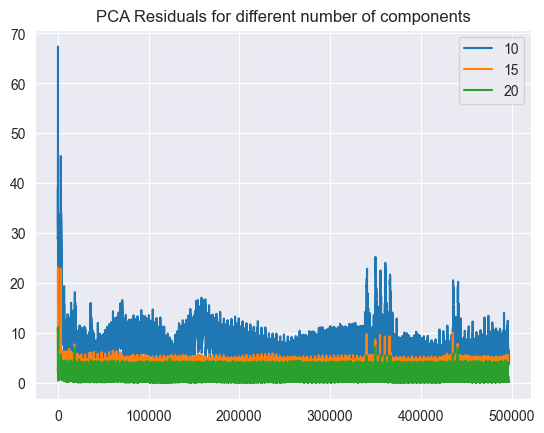

[Id
0         2.538500
1         2.538896
2         2.533555
3         2.534403
4         2.534000
            ...   
496795    0.141214
496796    0.206557
496797    0.219920
496798    0.202977
496799    0.184758
Length: 496800, dtype: float64, Id
0         0.858452
1         0.860000
2         0.861314
3         0.861863
4         0.862875
            ...   
496795    0.073338
496796    0.167333
496797    0.179039
496798    0.169011
496799    0.148650
Length: 496800, dtype: float64, Id
0         0.166472
1         0.166458
2         0.166489
3         0.166486
4         0.166454
            ...   
496795    0.012541
496796    0.003801
496797    0.005352
496798    0.004735
496799    0.005523
Length: 496800, dtype: float64]
None


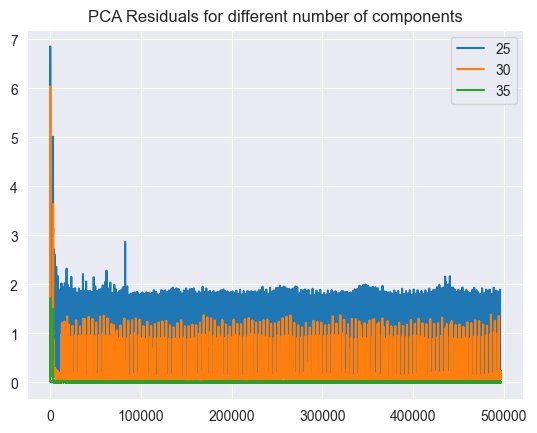

In [219]:
plot_pca_residuals(partial_residuals1, partial_components1, start_index=0)
plot_pca_residuals(partial_residuals2, partial_components2, start_index=0)
plot_pca_residuals(partial_residuals3, partial_components3, start_index=0)

In [220]:
# plot_pca_residuals(residuals, start_index=50000)

Analyzing the residuals in the train set.

[Id
0         2.538500
1         2.538896
2         2.533555
3         2.534403
4         2.534000
            ...   
496795    0.141214
496796    0.206557
496797    0.219920
496798    0.202977
496799    0.184758
Length: 496800, dtype: float64]
None


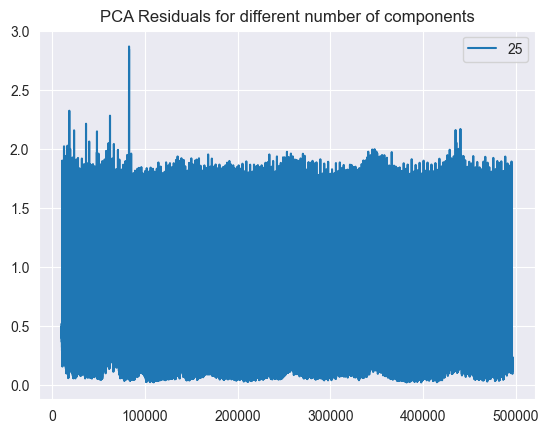

In [249]:
final_components = 25  # 25 good
start_index = 10000
final_pca = PCA(n_components=final_components)
final_pca.fit(relevant_train_data_df)
train_data_pca = final_pca.transform(relevant_train_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_train_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

Plotting residuals from the test set. From the values below, it can be noted that the threshold between 4 and 5 is a good choice as it captures just enough outliers in the data.

[Id
224959    2.438580
224960    2.439346
224961    2.424334
224962    2.380146
224963    2.375354
            ...   
449914    2.891990
449915    2.916629
449916    2.926606
449917    2.938391
449918    2.933320
Length: 224960, dtype: float64]
None


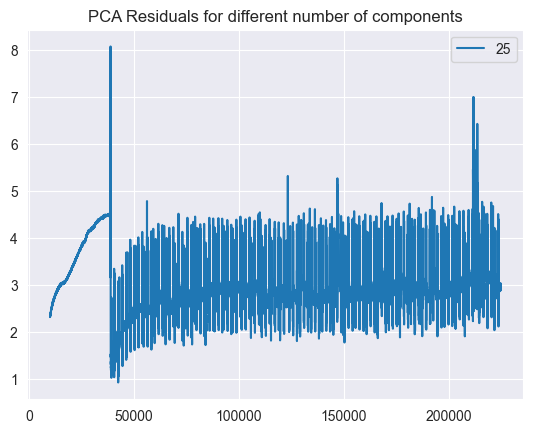

In [222]:
relevant_test_data_df = test_data_df[relevant_signals]

test_data_pca = final_pca.transform(relevant_test_data_df)
# Calculate residuals
residuals = calculate_residuals(relevant_test_data_df, final_pca)
plot_pca_residuals([residuals], components=[final_components], start_index=start_index)

Plotting residuals from the validation dataset and marking anomalies (red dashed vertical lines). As can be seen, some anomalies are properly detected. This is used to verify the submission for kaggle.

[Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64]
[  1754   1755   1756 ... 199738 199739 199740]


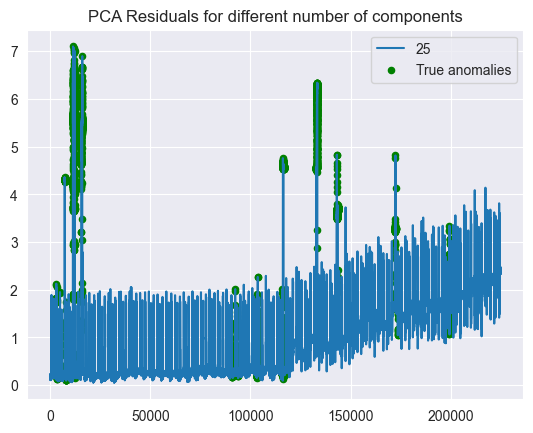

In [224]:
relevant_validation_data_df = val_data_df[relevant_signals]
validation_data_pca = final_pca.transform(relevant_validation_data_df)
# Calculate residuals
validation_residuals = calculate_residuals(relevant_validation_data_df, final_pca)

# Get indices of anomalies
anomaly_indices = np.where((val_data_df['Label'].to_numpy() == 1))[0]
plot_pca_residuals([validation_residuals], components=[final_components], start_index=0, true_labels=anomaly_indices)

Defining the allowed range for each of the signal which is set to be (1.5 * smallest_signal_residual, 1.5 * largest_signal_residual) to provide some safety margin. If the residual of a signal is out of this range, then the signal is considered an anomaly.

In [225]:
def calculate_thresholds(residuals, range_multiplier=1.5):
    return residuals.max() * range_multiplier


start_signal = 10000
trimmed_train_data_df = relevant_train_data_df.iloc[start_signal:, :]
train_residuals = calculate_residuals(trimmed_train_data_df, final_pca)
threshold = calculate_thresholds(train_residuals, range_multiplier=1.5)
print(threshold)

4.301609497302479


In [226]:
print(validation_residuals)

Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64


In [227]:
def find_anomalies_in_residuals(residuals, threshold):
    """
    Returns the set containing indices of anomalies in the residuals.
    """
    anomalies_indices = set()
    # Return indices where the residual is out of the allowed range using numpy
    for i, residual in enumerate(residuals):
        if residual > threshold:
            anomalies_indices.add(i)
    return anomalies_indices


predicted_anomalies = list(find_anomalies_in_residuals(validation_residuals, threshold))


[Id
0         0.184758
1         0.146763
2         0.145627
3         0.176135
4         0.202569
            ...   
224954    2.338033
224955    2.339943
224956    2.355958
224957    2.423998
224958    2.423238
Length: 224959, dtype: float64]
[  1754   1755   1756 ... 199738 199739 199740]


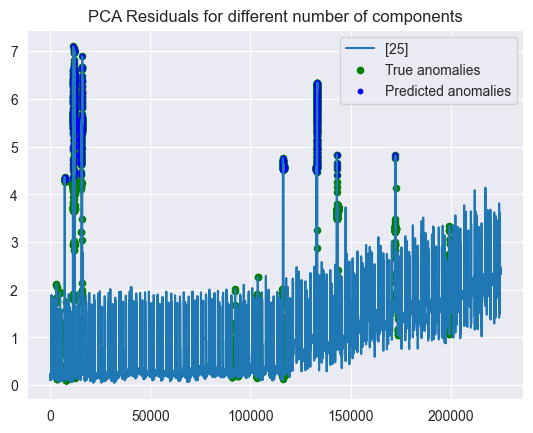

In [228]:
plot_pca_residuals([validation_residuals], components=[[25]], start_index=0, true_labels=anomaly_indices,
                   predicted_labels=predicted_anomalies)

Calculate metrics for the PCA model.

In [229]:
# Calculate the number of true positives, false positives, true negatives and false negatives
def calculate_statistics(predicted_anomalies, true_anomalies):
    true_positives = len(set(predicted_anomalies).intersection(set(true_anomalies)))
    false_positives = len(set(predicted_anomalies).difference(set(true_anomalies)))
    true_negatives = len(
        set(np.arange(len(validation_residuals.index))).difference(set(predicted_anomalies).union(set(true_anomalies))))
    false_negatives = len(set(true_anomalies).difference(set(predicted_anomalies)))
    return true_positives, false_positives, true_negatives, false_negatives


tp, fp, tn, fn = calculate_statistics(predicted_anomalies, anomaly_indices)
print(f"True positives: {tp}, False positives: {fp}, True negatives: {tn}, False negatives: {fn}")


def calculate_metrics(tp, fp, tn, fn):
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    return accuracy, precision, recall, f1_score


accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}")


True positives: 2177, False positives: 59, True negatives: 213864, False negatives: 8859
Accuracy: 0.960357220649096, Precision: 0.973613595706619, Recall: 0.19726350126857556, F1 score: 0.3280590717299578


Analyze several thresholds. Turns out that multiplying the max and min values in the train set by 4 gives the best results. For Kaggle submission.

In [230]:
def analyze_thresholds(residuals, true_anomalies, thresholds, range_multipliers):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    for i, threshold in enumerate(thresholds):
        predicted_anomalies = list(find_anomalies_in_residuals(residuals, threshold))
        tp, fp, tn, fn = calculate_statistics(predicted_anomalies, true_anomalies)
        accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        print(
            f"Threshold multiplier: {range_multipliers[i]}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 score: {f1_score}\n")
    return accuracies, precisions, recalls, f1_scores


threshold_multipliers = np.arange(0.4, 3, 0.2)
thresholds = [calculate_thresholds(train_residuals, range_multiplier=multiplier) for multiplier in
              threshold_multipliers]
accuracies, precisions, recalls, f1_scores = analyze_thresholds(validation_residuals, anomaly_indices, thresholds,
                                                                threshold_multipliers)

Threshold multiplier: 0.4, Accuracy: 0.6667437177441222, Precision: 0.07728012060142024, Recall: 0.5295396882928597, F1 score: 0.1348765823880356

Threshold multiplier: 0.6000000000000001, Accuracy: 0.8455051809440831, Precision: 0.1381319989015348, Recall: 0.41020297209133744, F1 score: 0.20666986235704993

Threshold multiplier: 0.8000000000000002, Accuracy: 0.9539827257411351, Precision: 0.5580448065173116, Recall: 0.2979340340703153, F1 score: 0.38846880907372394

Threshold multiplier: 1.0000000000000002, Accuracy: 0.9637267235362889, Precision: 0.8935413245758074, Recall: 0.2958499456324755, F1 score: 0.4445200816882232

Threshold multiplier: 1.2000000000000002, Accuracy: 0.9642734898359256, Precision: 0.954531676265535, Recall: 0.2853388909025009, F1 score: 0.439344262295082

Threshold multiplier: 1.4000000000000004, Accuracy: 0.9614774247751813, Precision: 0.9683794466403162, Recall: 0.2220007249003262, F1 score: 0.36119711042311664

Threshold multiplier: 1.6000000000000005, Accu

In [257]:
# Find anomalies in the test data

test_residuals = calculate_residuals(relevant_test_data_df, final_pca)
test_threshold = 4

test_anomalies = np.array(list(find_anomalies_in_residuals(test_residuals, test_threshold)))
print(test_anomalies)

test_labels = np.zeros(len(test_residuals))

test_labels[test_anomalies] = 1
print(len(test_labels))
indices = np.arange(len(test_residuals))
data_dict = {"ID": indices + 224959, "Label": test_labels.astype(int)}
test_anomalies_df = pd.DataFrame(data_dict)
# Set index to index
test_anomalies_df.set_index("ID", inplace=True, drop=True)
# Print anomalies - It's better to print DataFrame for clear visualisation
print(test_anomalies_df[test_anomalies_df["Label"]==1])
test_anomalies_df.to_csv("test_anomalies_pca.csv")

[213705 213706 123366 123367   6798   6799   6800   6801   6802 211631
 211632 211633 211634 211635 211636 211637 211638 211639 211640 211641
 211642 211643 211644 211645 211646 211647 211648 211649 211650 211651
 211652 211653 211654 211655 211656 211657 211658 211659 211660 211661
 211662 211663 211664 211665 211666 211667 211668 211669 211670 211671
 211672 211673 211674 211675 211676 211677 211678 211679 211680 211681
 211682 211683 211684 211685 211686 211687 211688 211689 211690 211691
 211692 211693 211694 211695 211696 211697 211698 211699 211700 211701
 211702 211703 211704 211705 211706 211707 211708 211709 211710 211711
 211712 211713 211714 211715 211716 211717 211718 211719 211720 211721
 211722 211723 211724 211725 211726 211727 211728 211729 211730 211731
 211732 211733 211734 211735 211736 211737 211738 211739 211740 211741
 211742 211743 211744 211745 211746 211747 211748 211749 211750 211751
 211752 211753 211754 211755 211756 211757 211758 211759 211760 211761
 21176

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

FIT101 displays interesting temporal behavior.

### 4a. Print relevant plots and/or metrics to determine the parameters.

In [259]:
train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")
val_data_path = os.path.join(os.getcwd(), "data", "val_data.csv")
test_data_path = os.path.join(os.getcwd(), "data", "test_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)
val_data_df = pd.read_csv(val_data_path)
val_data_df.set_index('Id', inplace=True)
test_data_df = pd.read_csv(test_data_path)
test_data_df.set_index('Id', inplace=True)

start_index = 10000
relevant_train_data_df = train_data_df.iloc[start_index:, :].copy()
relevant_val_data_df = val_data_df.iloc[start_index:, :].copy()
relevant_test_data_df = test_data_df.iloc[start_index:, :].copy()

<Figure size 640x480 with 0 Axes>

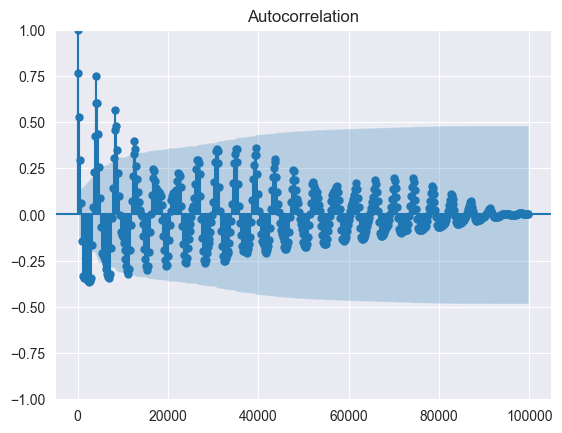

In [260]:
# Plot the autocorrelations for the relevant attributes
start_time = 10000
plotting_time = 100000
plt.clf()
plot_acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time, :], lags=list(range(0, plotting_time, 200)))
plt.show()

As can be seen in the plot above, the signal shows some cyclic behavior.

In [261]:
from statsmodels.tsa.stattools import acf

fit101_acf = acf(relevant_train_data_df[["FIT101"]].iloc[: plotting_time, :], nlags=plotting_time)[::200]
# Find 10 largest values in the acf
print(fit101_acf)
largest_acf_values = np.argsort(fit101_acf, axis=0)[-10:]
print(f"10 largest values in the acf: {largest_acf_values * 200}")

[ 1.00000000e+00  7.63081602e-01  5.29141835e-01  2.93594062e-01
  6.37937413e-02 -1.44368784e-01 -3.33698395e-01 -3.45618389e-01
 -3.46219512e-01 -3.37306164e-01 -3.41345791e-01 -3.51086139e-01
 -3.59139737e-01 -3.67651123e-01 -3.61817880e-01 -3.41374859e-01
 -1.64781376e-01  3.90559823e-02  2.32262960e-01  4.25688904e-01
  6.04754704e-01  7.47899266e-01  6.04738460e-01  4.33241078e-01
  2.59493779e-01  8.77943172e-02 -6.59622805e-02 -2.07254553e-01
 -2.21167827e-01 -2.31317070e-01 -2.46971393e-01 -2.68492643e-01
 -2.96338113e-01 -3.20137922e-01 -3.38419694e-01 -3.42493694e-01
 -3.19694374e-01 -1.81794002e-01 -1.75066719e-02  1.44884134e-01
  3.07615838e-01  4.56451616e-01  5.65339375e-01  4.76682499e-01
  3.46695518e-01  2.23696564e-01  1.02392699e-01 -1.14062616e-03
 -9.45929348e-02 -1.12301678e-01 -1.23106596e-01 -1.52426487e-01
 -1.93636791e-01 -2.41671099e-01 -2.80088923e-01 -3.05460643e-01
 -3.22134532e-01 -2.97363320e-01 -1.91123203e-01 -5.73468109e-02
  7.53353154e-02  2.07498

In [262]:
start_lag = 1
end_lag = 5001
interval = 500

From the analysis above, we can deduce that the period of this signal is around 4200 as the autocorrelation has a large spike there. Thus, our first attempt will consider lags around this value.

In [263]:
# Use autoregression to predict the next values based on the previous ones

from sklearn.linear_model import ARDRegression


def get_features_targets(time_window_range, data, intervals=1, feature="FIT101"):
    # Collect arrays of the features and labels
    features = []
    targets = []
    signal_array = data[feature].to_numpy().squeeze()
    for i in range(time_window_range, len(data)):
        time_window = np.flip(signal_array[i - time_window_range:i:intervals])
        target = signal_array[i]
        features.append(time_window)
        targets.append(target)

    features = np.array(features)
    targets = np.array(targets)
    return features, targets


def predict_and_plot(features, targets, model):
    predictions = model.predict(features)
    residuals = predictions - targets
    plt.plot(residuals, label="Residuals")
    plt.legend()
    plt.show()


def run_model(time_window_range, data, intervals=1, feature="FIT101"):
    features, targets = get_features_targets(time_window_range, data, intervals, feature)
    ard = ARDRegression()
    ard.fit(features, targets)
    predict_and_plot(features, targets, ard)
    return ard


def get_ar_residuals(targets, predictions):
    return predictions - targets


In [264]:
ard = ARDRegression()
features, targets = get_features_targets(4200, relevant_train_data_df, intervals=2)

print(features.shape)
print(targets.shape)

(482600, 2100)
(482600,)


In [265]:
# Train the model
ard.fit(features, targets)

ARDRegression()

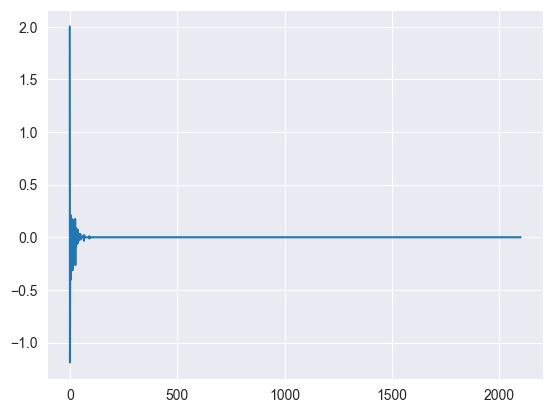

In [266]:
# Plot the coefficients
plt.plot(ard.coef_)

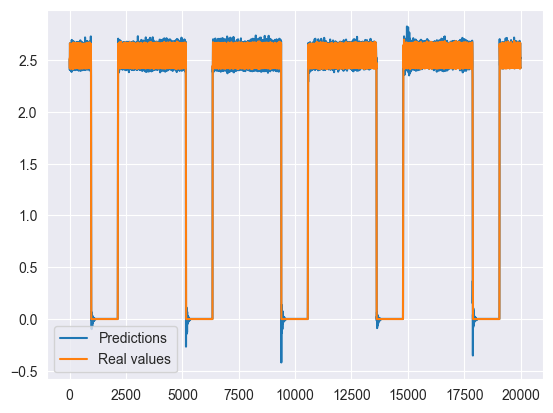

In [267]:
# Predict the values
predictions = ard.predict(features)
plt.plot(predictions[300000:320000], label="Predictions")
plt.plot(targets[300000:320000], label="Real values")
plt.legend()

As can be seen above, the predicted and real values are close to the real ones on larger scale.

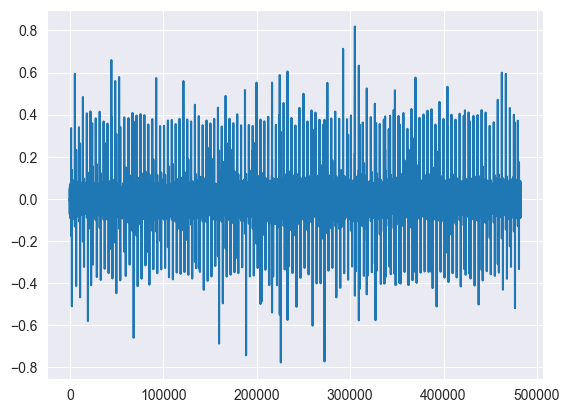

In [268]:
plt.clf()

train_residuals = get_ar_residuals(targets, predictions)
plt.plot(train_residuals)

Now taking the smaller time windows. As we can see, residual look similar.

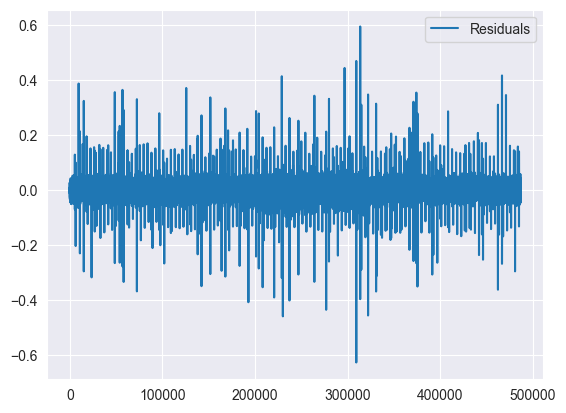

In [269]:
ard_small = run_model(100, relevant_train_data_df)

Taking different signals.

<Figure size 640x480 with 0 Axes>

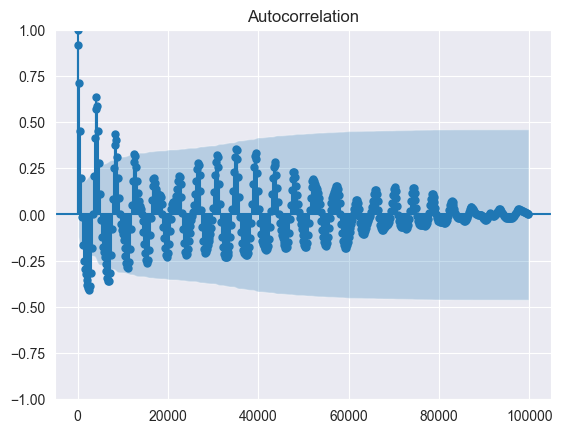

<Figure size 640x480 with 0 Axes>

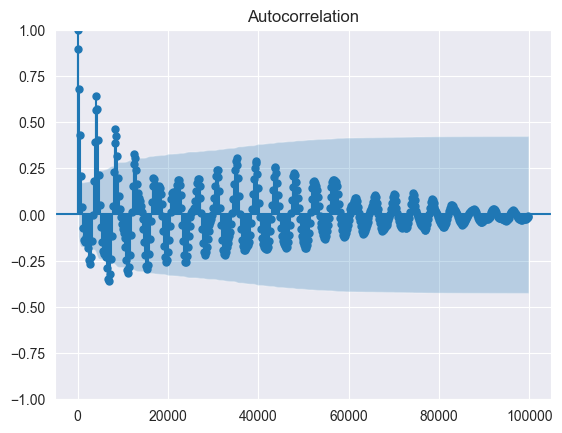

In [270]:
# Plot the autocorrelations for the signal LIT101
start_time = 10000
plotting_time = 100000
plt.clf()
plot_acf(relevant_train_data_df["LIT101"][: plotting_time], lags=list(range(0, plotting_time, 200)))
plt.show()

plt.clf()
plot_acf(relevant_train_data_df["LIT401"][: plotting_time], lags=list(range(0, plotting_time, 200)))
plt.show()

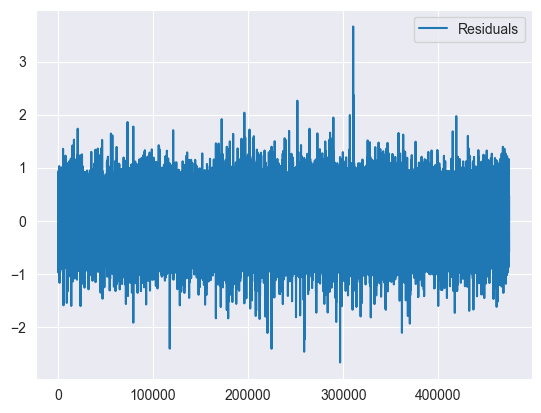

In [ ]:
# Continous signals
LIT101_ar = run_model(2200, relevant_train_data_df[10000:], feature="LIT101", intervals=2)
LIT401_ar = run_model(2200, relevant_train_data_df[10000:], feature="LIT401", intervals=2)



In [ ]:
# Binary signals
P101_ar = run_model(100, relevant_train_data_df[10000:], feature="P101")

In [ ]:
# Plot the coefficients
plt.clf()
plt.plot(LIT101_ar.coef_, label="LIT101")
plt.plot(LIT401_ar.coef_, label="LIT401")
plt.legend()
plt.show()

Applying differencing.

In [ ]:
relevant_train_data_df["FIT101_diff"] = relevant_train_data_df["FIT101"].diff()
print(relevant_train_data_df["FIT101_diff"])
# Replace nan with zero
relevant_train_data_df["FIT101_diff"] = relevant_train_data_df["FIT101_diff"].fillna(0)

plt.plot(relevant_train_data_df["FIT101_diff"])
plt.show()

In [ ]:
# Training the model
ard_FIT101_diff = run_model(4400, relevant_train_data_df, feature="FIT101_diff", intervals=5)

### 4b. Plots to study the detected anomalies

In [ ]:
# Plot the anomalies
def find_anomalies(residuals, threshold):
    return np.where(np.abs(residuals) > threshold)[0]

def plot_threshold(residuals, threshold, true_anomalies=None, predicted_anomalies=None):
    plt.plot(residuals, label="Residual")
    plt.hlines(threshold, 0, len(residuals), label="Threshold", linestyle="--", color="red")
    plt.hlines(-threshold, 0, len(residuals), linestyle="--", color="red")

    if true_anomalies is not None:
        plt.scatter(true_anomalies, residuals[true_anomalies], label="True anomalies", color="green", s=20)

    if predicted_anomalies is not None:
        plt.scatter(predicted_anomalies, residuals[predicted_anomalies], label="Predicted anomalies", color="blue",
                    s=10)
    plt.legend()
    plt.show()


features, targets = get_features_targets(100, relevant_train_data_df)

In [ ]:
# Using the FIT101 signal
threshold = 0.3
ard_final = run_model(100, relevant_train_data_df)
train_residuals = get_ar_residuals(targets, ard_final.predict(features))
plot_threshold(train_residuals, threshold)


In [ ]:
def validate_results(train_data, val_data, time_window_range, signal, threshold=None, interval=1):
    val_features, val_targets = get_features_targets(time_window_range, val_data, intervals=interval, feature=signal)
    train_features, train_targets = get_features_targets(time_window_range, train_data, intervals=interval,
                                                         feature=signal)

    model = ARDRegression()
    model.fit(train_features, train_targets)
    if threshold is None:
        # Threshold is determined using the validation set
        train_residuals = get_ar_residuals(train_targets, model.predict(train_features))
        threshold = np.max(np.abs(train_residuals))
    predictions = model.predict(val_features)
    val_residuals = get_ar_residuals(val_targets, predictions)
    predicted_anomalies = find_anomalies(val_residuals, threshold)
    true_anomalies = np.where(relevant_val_data_df["Label"] == 1)[0]
    plot_threshold(val_residuals, threshold, true_anomalies, predicted_anomalies)
    return predicted_anomalies, residuals

In [ ]:
# The validation dataset FIT101
validation_signal = "FIT101"

anomalies, residuals = validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

In [ ]:
# The validation dataset LIT101
validation_signal = "LIT101"

LIT101_anomalies, LIT101_residuals =  validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

In [ ]:
# The validation dataset LIT401
validation_signal = "LIT401"

LIT401_anomalies, LIT401_residuals = validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

In [ ]:
# The validation dataset LIT301
validation_signal = "LIT301"

LIT301_anomalies, LIT301_residuals = validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

In [ ]:
# The validation dataset with differencing
relevant_train_data_df["LIT301_diff"] = relevant_train_data_df["LIT301"].diff()
relevant_train_data_df["LIT301_diff"] = relevant_train_data_df["LIT301_diff"].fillna(0)
relevant_val_data_df["LIT301_diff"] = relevant_val_data_df["LIT301"].diff()
relevant_val_data_df["LIT301_diff"] = relevant_val_data_df["LIT301_diff"].fillna(0)

validation_signal = "LIT301_diff"

validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)


In [ ]:
# Try out binary signals
validation_signal = "P101"
validate_results(relevant_train_data_df, relevant_val_data_df, 100, validation_signal)

In [ ]:
# Get predicted anomalies using the best performing signal LIT301
true_anomalies = np.where(relevant_val_data_df["Label"] == 1)[0]
# Calculate the metrics
tp, fp, tn, fn = calculate_statistics(predicted_anomalies, LIT301_anomalies)
accuracy, precision, recall, f1_score = calculate_metrics(tp, fp, tn, fn)
# Print the intersection of the predicted and true anomalies
print("Number of predicted anomalies: ", len(LIT301_anomalies))
print("Number of true anomalies: ", len(true_anomalies))
print("Intersection: ", np.intersect1d(LIT301_anomalies, true_anomalies))
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

### 4c. Analysis and answers to the questions

Two sizes of sliding windows were tested to see if the size of the window has an impact on the performance of the model. The results show that the size of the window does not have a significant impact on the performance of the model and the difference in performance between the model with a window size of 100 and 4400 is negligible. While, a huge disadvantage of using a large window is its computational cost. Moreover, with larger time windows, we are not able to detect anomalies in the beginning of the measurements. Therefore, a window size of 100 was chosen for the rest of the analysis.
Even though most of the signals are periodically correlated, the correlation is not strong enough to make a long-term prediction useful.
The predictive performance did not seem to increase after applying differencing. This might be due to the fact that the signals are not periodic enough.
From the plots above, it is clear that the model is able to detect contextual anomalies (groups of anomalies) on a continuous data (sensors with continuous signals). Moreover, from the analysis on the validation set it looks like the model performs best on data coming from theLevel Transmitter sensors (LIT).